## Setup

In [1]:
DEV_MODE = False

In [2]:
%uv pip install -Uq pip uv
%uv pip install --system -q ipykernel modal litellm unsloth zenml rich datasets huggingface-hub unsloth_zoo
!zenml init


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
/usr/local/lib/python3.12/site-packages/zenml/utils/exception_utils.py:61: SyntaxWarning: invalid escape sequence '\d'
  line_pattern = re.compile(f'File "{source_file}", line (\d+),')
Initializing the ZenML global configuration version to 0.84.2
⠋ Initializing ZenML repository at /root.
⠙ Initializing ZenML repository at /root.
⠹ Initializing ZenML repository at /root.
⠸ Initializing ZenML repository at /root.
⠼ Initializing ZenML repository at /root.
⠴ Initializing ZenML repository at /root.
⠦ Initializing ZenML repository at /root.
⠇ Initializing ZenML repository at /root.
⠋ Initializing ZenML repository at /root.
⠙ Initializing ZenML repository at /root.
⠹ Initializing ZenML repository at /root.
⠸ Initializing ZenML repository at /root.
⠼ Initializing ZenML repository at /root.
⠴ Initializing ZenML repository at /root.
⠦ Initializing ZenML repository a

In [3]:
import os
import json
import litellm

import logging
from rich.console import Console
from rich.panel import Panel
from rich.table import Table
from rich import print, inspect
from datasets import load_dataset
from collections import Counter
import matplotlib.pyplot as plt
from typing import Tuple
from openai import OpenAI

if not DEV_MODE:
    import unsloth
    import torch
    from transformers import AutoTokenizer
    from peft import PeftModel

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [25]:
plt.rcParams["figure.dpi"] = 150  # sharper default output for matplotlib

In [4]:
# --- Configuration --

OPENROUTER_API_KEY = os.getenv("DSWORKSHOP_OPENROUTER_API_KEY")
TEACHER_MODEL = "deepseek/deepseek-r1-0528"
STUDENT_MODEL_ID = "zenml/deepseek-cuad-gemma-3-12b-it-bnb-4bit"
BASE_MODEL_ID = "unsloth/gemma-3-12b-it-unsloth-bnb-4bit"
DATASET_ID = "zenml/cuad-deepseek"
NUM_SAMPLES = 3

# --- Initial Setup ---
console = Console()

# Suppress verbose logging from libraries for a cleaner output
litellm.suppress_debug_info = True
logging.getLogger("LiteLLM").setLevel(logging.ERROR)
logging.getLogger("httpx").setLevel(logging.ERROR)
logging.getLogger("unsloth").setLevel(logging.ERROR)

# Check for required API key
if not OPENROUTER_API_KEY:
    console.print("[bold red]Warning: OPENROUTER_API_KEY not set.[/bold red]")
    console.print("The DeepSeek 'teacher' model will be skipped. Set the key and re-run to include it.")

In [5]:
# The legal clause categories from CUAD, used in our prompt to the model
LEGAL_LABEL_SCHEMA = [
    "Anti-Assignment", "Audit Rights", "Cap on Liability", "Change of Control",
    "Competitive Restriction Exception", "Covenant Not to Sue", "Effective Date",
    "Exclusivity", "Expiration Date", "Governing Law", "Insurance",
    "IP Ownership Assignment", "Joint IP Ownership", "License Grant", "Liquidated Damages",
    "Minimum Commitment", "Most Favored Nation", "Non-Compete", "Non-Disparagement",
    "Non-Solicit of Customers", "Non-Solicit of Employees", "Non-Transferable License",
    "Notice to Terminate Renewal", "Post-Termination Services", "Price Restriction",
    "Renewal Term", "Revenue/Profit Sharing", "Right of First Refusal", "Source Code Escrow",
    "Termination for Convenience", "Third Party Beneficiary", "Uncapped Liability",
    "Volume Restriction", "Warranty Duration", "Affiliate License-Licensee",
    "Affiliate License-Licensor", "Irrevocable License", "NONE"
]

In [6]:
@torch.no_grad()
def load_student_model():
    """Loads the fine-tuned 12B parameter 'student' model using Unsloth for efficiency."""
    console.print(f"\n[bold blue]Loading fine-tuned student model: {STUDENT_MODEL_ID}[/bold blue]")
    if not torch.cuda.is_available():
        console.print("[bold yellow]Warning: CUDA not available. Skipping student model loading.[/bold yellow]")
        return None, None
    try:
        model, tokenizer = unsloth.FastLanguageModel.from_pretrained(
            model_name=BASE_MODEL_ID,
            max_seq_length=4096,
            load_in_4bit=True,
        )
        unsloth.FastLanguageModel.for_inference(model)
        
        # Load LoRA adapters from the Hub to apply our fine-tuning
        model = PeftModel.from_pretrained(model, STUDENT_MODEL_ID)
        
        # Configure tokenizer with the Gemma 3 chat template for correct prompt formatting
        tokenizer = unsloth.chat_templates.get_chat_template(tokenizer, chat_template="gemma-3")
        
        console.print("[bold green]✓ Student model loaded successfully on GPU.[/bold green]")
        return model, tokenizer
    except Exception as e:
        console.print(f"[bold red]Error loading student model: {e}[/bold red]")
        console.print("This might be due to a missing Hugging Face token, network issues, or insufficient VRAM.")
        return None, None

@torch.no_grad()
def run_student_inference(messages, model, tokenizer):
    """Runs inference using our smaller, fine-tuned 'student' model."""
    if model is None or tokenizer is None:
        return "Skipped: Student model not loaded (check GPU availability)."
    
    # Format the prompt using the model's specific chat template
    prompt_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True, tokenize=False)
    inputs = tokenizer([prompt_text], return_tensors="pt").to("cuda")
    
    # Generate the response
    outputs = model.generate(**inputs, max_new_tokens=1024, use_cache=True)
    response_text = tokenizer.batch_decode(outputs)[0]
    
    # Extract only the newly generated part of the response, not the original prompt
    return response_text[len(prompt_text):].strip()

student_model, student_tokenizer = load_student_model()

Loading fine-tuned student model: zenml/deepseek-cuad-gemma-3-12b-it-bnb-4bit

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


==((====))==  Unsloth 2025.8.6: Fast Gemma3 patching. Transformers: 4.55.0.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.494 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 8.0. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/2.84G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/670 [00:00<?, ?B/s]

adapter_config.json: 0.00B [00:00, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/262M [00:00<?, ?B/s]

✓ Student model loaded successfully on GPU.

In [7]:
dataset = load_dataset(DATASET_ID, split="test")
dataset[0]

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/57.9M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/7.22M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/7.27M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/26124 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3266 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3266 [00:00<?, ? examples/s]

{'clause': 'Voice-Over Appearances. If requested by Company, North shall make one (1) voice over appearance duri',
 'clause_with_context': "hall pay North an additional fee for such appearance(s) as set forth in paragraph 6.d. below. North has no obligation  to make such appearance.\n\n  c. Voice-Over Appearances. If requested by Company, North shall make one (1) voice over appearance during the Term. The voice over  appearance shall take place at North's personal residence or at another mutually agreed upon location in Wisconsin, and s",
 'label': 'NONE',
 'contract_name': 'PerformanceSportsBrandsInc_20110909_S-1_EX-10.10_7220214_EX-10.10_Endorsement Agreement',
 'contract_type': '10.10_Endorsement Agreement',
 'rationale': 'The clause is classified as **NONE** because it does not align with standard endorsement agreement categories. Key elements driving this conclusion:  \n\n1. **Conditional Obligation**:  \n   - Language: *“If requested by Company, North **shall** make one (1) voice

![](https://github.com/strickvl/deepseek-distillation-workshop-2025/blob/main/assets/workshop-cover.png?raw=true)

# DeepSeek Distillation Workshop

*August 16, 2025*


## Demo: What we're building

In [8]:
dataset[0]

{'clause': 'Voice-Over Appearances. If requested by Company, North shall make one (1) voice over appearance duri',
 'clause_with_context': "hall pay North an additional fee for such appearance(s) as set forth in paragraph 6.d. below. North has no obligation  to make such appearance.\n\n  c. Voice-Over Appearances. If requested by Company, North shall make one (1) voice over appearance during the Term. The voice over  appearance shall take place at North's personal residence or at another mutually agreed upon location in Wisconsin, and s",
 'label': 'NONE',
 'contract_name': 'PerformanceSportsBrandsInc_20110909_S-1_EX-10.10_7220214_EX-10.10_Endorsement Agreement',
 'contract_type': '10.10_Endorsement Agreement',
 'rationale': 'The clause is classified as **NONE** because it does not align with standard endorsement agreement categories. Key elements driving this conclusion:  \n\n1. **Conditional Obligation**:  \n   - Language: *“If requested by Company, North **shall** make one (1) voice

In [9]:
def create_prompt_messages(sample):
    """Creates the JSON-based prompt structured for our models."""
    input_json = json.dumps({
        "task": "classify_legal_clause",
        "instructions": 'Analyze the legal clause and provide a detailed rationale for why it belongs to a specific category, then classify it according to the provided schema. IMPORTANT: First explain your reasoning thoroughly, then provide the label. Your output must be valid JSON. Example format: {"rationale": "This clause describes... because...", "label": "Termination for Convenience"}',
        "schema": {
            "rationale": "Detailed explanation of why the clause belongs to this category",
            "label": "The classification category from the list of valid labels",
        },
        "valid_labels": LEGAL_LABEL_SCHEMA,
        "inputs": {
            "clause": sample["clause"].strip(),
            "clause_with_context": sample["clause_with_context"].strip(),
            "contract_type": sample.get("contract_type", "").strip() or "Unknown",
        },
    }, ensure_ascii=False)
    
    # Gemma 3 expects a specific chat format, which we create here
    return [{"role": "user", "content": [{"type": "text", "text": input_json}]}]

def run_teacher_inference(messages):
    """Runs inference using the large DeepSeek-R1 'teacher' model via OpenRouter."""
    if not OPENROUTER_API_KEY:
        return "Skipped: OPENROUTER_API_KEY not set."
    try:
        response = litellm.completion(
            model=f"openrouter/{TEACHER_MODEL}",
            messages=messages,
            temperature=0.1,
            max_tokens=1024,
            response_format={"type": "json_object"},
        )
        return response.choices[0].message.content
    except Exception as e:
        return f"API Error: {str(e)}"


def parse_response(response_text):
    """Extracts and parses the JSON from a model's response string."""
    try:
        json_start = response_text.find("{")
        json_end = response_text.rfind("}") + 1
        if json_start >= 0 and json_end > json_start:
            json_str = response_text[json_start:json_end]
            parsed = json.loads(json_str)
            label = parsed.get("label", "N/A")
            rationale = parsed.get("rationale", "N/A")
            return label, rationale
        return "Parsing Error", response_text
    except json.JSONDecodeError:
        return "JSON Error", response_text
    except Exception as e:
        return f"Unknown Error: {e}", response_text

In [10]:
sample_number = 12
input_clause = dataset[sample_number]["clause"]

actual_label = dataset[sample_number]["label"]

messages = create_prompt_messages(dataset[sample_number])
teacher_response = run_teacher_inference(messages)

label, rationale = parse_response(teacher_response)

print(f"Input clause: {input_clause}")

print(f"Actual Label: {actual_label}")
print(f"Predicted Label: {label}")

print(f"Rationale: {rationale}")


Input clause: Ingram Micro

Actual Label: Parties

Predicted Label: NONE

Rationale: The clause 'Ingram Micro' appears within the context of identifying a contracting party ('Ingram Micro, 
a corporation organized under the laws of the State of California...'). It does not establish any substantive 
obligation, right, restriction, or operational term characteristic of the defined classification categories. The 
valid labels pertain to specific legal mechanisms (e.g., liability caps, termination rights, IP ownership) or 
defined contractual structures (e.g., exclusivity, governing law). Naming a party is a fundamental element of 
contract formation but does not align with any of the substantive clause types listed in the schema. Therefore, it 
falls outside the scope of the provided classification categories.

In [11]:
# teacher_response

In [12]:
student_response = run_student_inference(messages, student_model, student_tokenizer)
student_label, student_rationale = parse_response(student_response)

print(f"Actual label: {actual_label}")
print(f"Student model predicted label: {student_label}")
print(f"Student model rationale: {student_rationale}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Actual label: Parties

Student model predicted label: Parties

Student model rationale: **Classification: Parties**  
This clause is classified as "Parties" because it **explicitly identifies the entities entering into the contract**
and provides key details about them.  

**Key Elements and Reasoning**:  
1. **Identification of Ingram Micro**: The clause names "Ingram Micro, a corporation organized under the laws of 
the State of California" and specifies its business address. This establishes Ingram Micro as a legal entity and 
defines its jurisdiction.  
2. **Contract Type Context**: In a **Distributor Agreement**, defining the parties (supplier and distributor) is 
foundational. This clause serves that purpose by naming Ingram Micro as one party.  
3. **Legal Requirements**: Describing a corporation’s formation under California law and its registered address 
fulfills legal requirements for clarity and enforceability.  

**Function**: This clause’s primary role is to define *who* is bound by the agreement, ensuring there is no 
ambiguity about the contracting parties. It does not address obligations, payment terms, or other operational 
clauses, which further supports its classification as "Parties."

In [ ]:
# print(student_response)

![](https://github.com/strickvl/deepseek-distillation-workshop-2025/blob/main/assets/workshop-overview.png?raw=true)

### Links

Workshop Notebook:
https://github.com/strickvl/deepseek-distillation-workshop-2025 (you are already
here ✅)

CUAD augmented dataset: https://huggingface.co/datasets/zenml/cuad-deepseek

Finetuned / distilled Gemma3 model: https://huggingface.co/zenml/deepseek-cuad-gemma-3-12b-it-bnb-4bit

To learn more about ZenML: visit https://zenml.io or https://github.com/zenml-io/zenml 

![](https://m.media-amazon.com/images/I/81X-KhyWcCL._SY385_.jpg)

To pre-order the book: https://tinyurl.com/deepseek-packt-2025

## Workshop Quick Overview

1. The CUAD dataset
2. Synthetic data generation with DeepSeek R1
3. Finetuning Gemma3 using distilled data
4. Evaluation
5. What next? (Production considerations)

## The CUAD Use Case

In [13]:
first_item = dataset[2]
first_item.pop('rationale')
first_item.pop('reasoning_trace')
print(first_item)

{
    'clause': 'access is reasonably required by the other, including without limitation, for audit, accounting and 
litigation purposes.',
    'clause_with_context': 'ther (other than data and information subject to any attorney/client or other 
privilege), insofar as such\n\n                                       27\n\naccess is reasonably required by the 
other, including without limitation, for audit, accounting and litigation purposes.\n\n     (c) Notwithstanding the
foregoing, either party may destroy or otherwise dispose of any information at any time in accordance with the 
corporat',
    'label': 'Audit Rights',
    'contract_name': 'FIDELITYNATIONALINFORMATIONSERVICES,INC_08_05_2009-EX-10.3-INTELLECTUAL PROPERTY AGREEMENT',
    'contract_type': 'INTELLECTUAL PROPERTY AGREEMENT',
    'index': 9513,
    'timestamp': '2025-05-08T19:18:02.721799',
    'model': 'deepseek/deepseek-r1',
    'temperature': 0.2,
    'top_p': 0.95
}

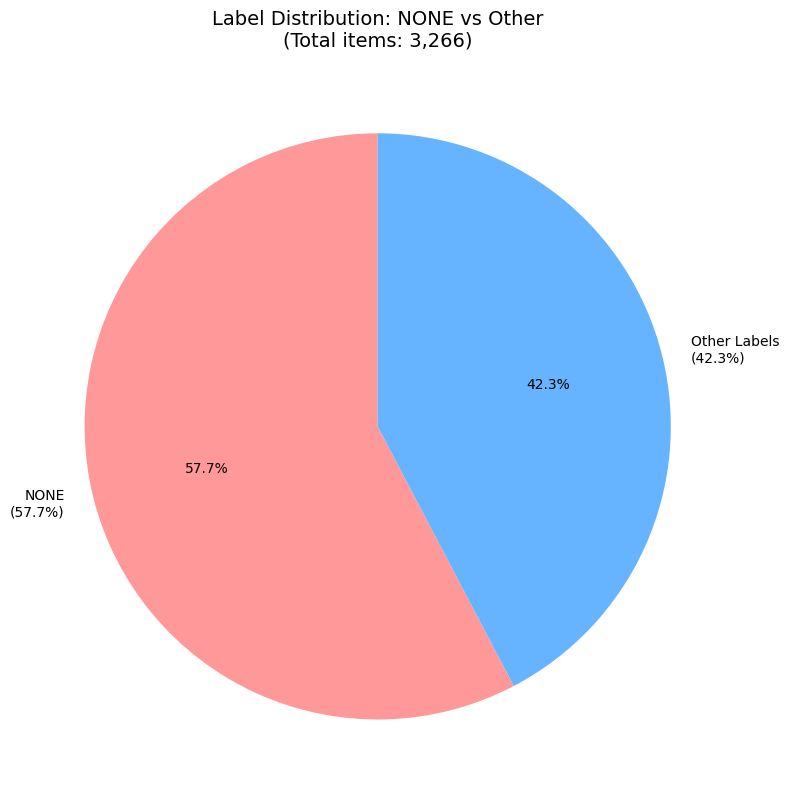

In [14]:
def count_none_vs_other_labels(dataset) -> Tuple[int, int]:
    labels = [item['label'] for item in dataset]
    none_count = sum(1 for label in labels if label == 'NONE')
    return none_count, len(labels) - none_count

none_count, other_count = count_none_vs_other_labels(dataset)
total = none_count + other_count
none_pct, other_pct = (none_count / total) * 100, (other_count / total) * 100

plt.figure(figsize=(8, 8))
plt.pie([none_count, other_count], 
        labels=[f"NONE\n({none_pct:.1f}%)", f"Other Labels\n({other_pct:.1f}%)"],
        colors=['#ff9999', '#66b3ff'], autopct='%1.1f%%', startangle=90)
plt.title(f'Label Distribution: NONE vs Other\n(Total items: {total:,})', fontsize=14, pad=20)
plt.axis('equal')
plt.tight_layout()
plt.show()

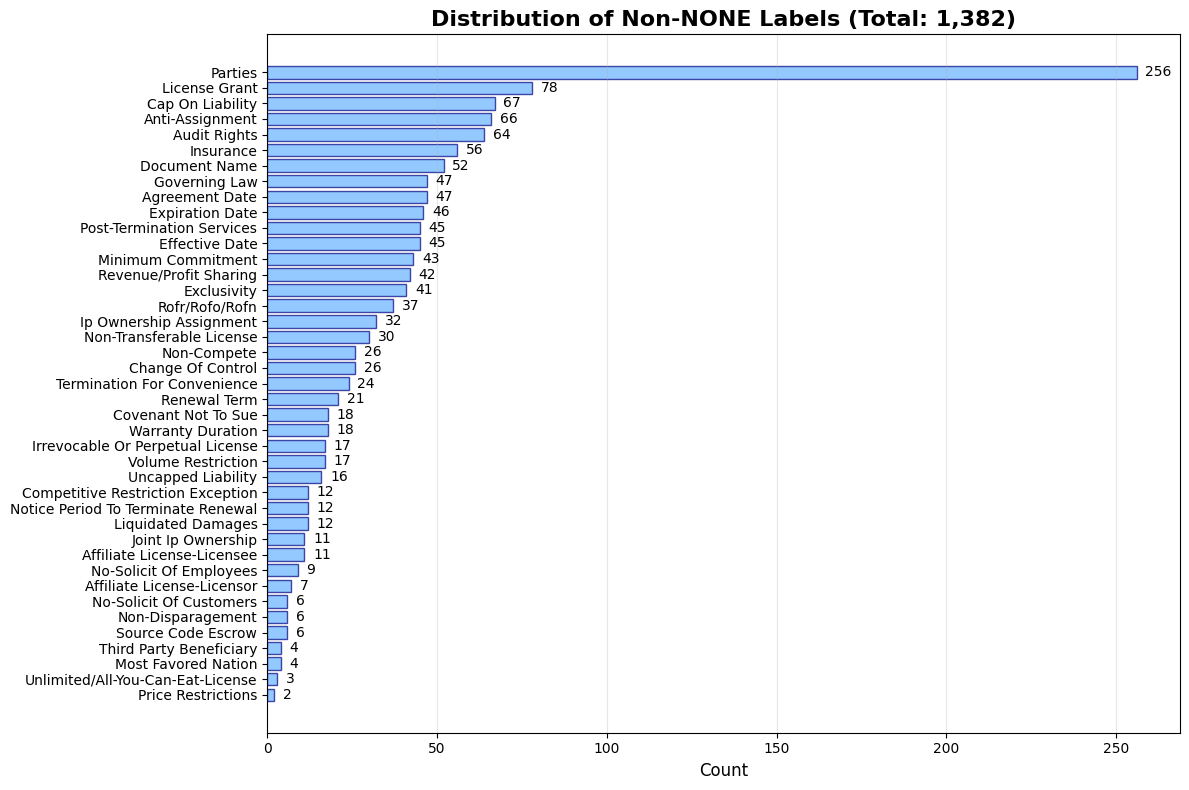

In [15]:
def get_non_none_label_counts(dataset) -> dict:
    labels = [item['label'] for item in dataset if item['label'] != 'NONE']
    return dict(Counter(labels))

label_counts = get_non_none_label_counts(dataset)
sorted_items = sorted(label_counts.items(), key=lambda x: x[1])
labels, counts = zip(*sorted_items)
total = sum(counts)

plt.figure(figsize=(12, 8))
bars = plt.barh(labels, counts, color='#66b3ff', edgecolor='navy', alpha=0.7)
plt.title(f'Distribution of Non-NONE Labels (Total: {total:,})', fontsize=16, fontweight='bold')
plt.xlabel('Count', fontsize=12)
plt.grid(axis='x', alpha=0.3)
for bar, count in zip(bars, counts):
    plt.text(bar.get_width() + max(counts)*0.01, bar.get_y() + bar.get_height()/2, 
             str(count), va='center', fontsize=10)
plt.tight_layout()
plt.show()

In [16]:
sample_item = dataset[8]

print(f"Input: {sample_item['clause']}")
print("-" * 100)
print(f"Output: {sample_item['label']}")

Input: Neither Party shall sell, transfer or assign this Agreement or the rights or obligations hereunder, without 
the prior written consent of the other Party, such consent not to be unreasonably withheld or delayed.

----------------------------------------------------------------------------------------------------

Output: Anti-Assignment

## Finetuning & Distillation for CUAD

### 🔍 Quick Assessment Questions

Before starting your finetuning project, ask:

| Question | ✅ Good Example | ❌ Poor Example |
|----------|-----------------|-----------------|
| 1. Can you define success with numbers? | "95% accuracy in extracting order IDs" | "Better customer satisfaction" |
| 2. Is your data ready? | "We have 1000 labeled support tickets" | "We could manually label some emails" |
| 3. Is the task consistent? | "Convert email to 5 specific fields" | "Respond naturally to customers" |
| 4. Can a human verify correctness? | "Check if extracted date matches document" | "Evaluate if response is creative" |


### 🎯 Good Use Cases

| Good Use Cases ✅ | Why It Works | Example | Data Requirements |
|------------------|--------------|---------|-------------------|
| **Structured Data Extraction** | Clear inputs/outputs, easily measurable accuracy | Extracting order details from customer emails (`order_id`, `issue_type`, `priority`) | 500-1000 annotated emails |
| **Domain-Specific Classification** | Well-defined categories, objective evaluation | Categorizing support tickets by department (Billing/Technical/Account) | 1000+ labeled examples per category |
| **Standardized Response Generation** | Consistent format, verifiable accuracy | Generating technical troubleshooting responses from documentation | 500+ pairs of queries and approved responses |
| **Form/Document Parsing** | Structured output, clear success metrics | Extracting fields from invoices (date, amount, vendor) | 300+ annotated documents |
| **Code Comment Generation** | Specific domain, measurable quality | Generating docstrings for Python functions | 1000+ function/docstring pairs |


### ❌ Not-So-Good Use Cases
| Challenging Use Cases ⚠️ | Why It's Tricky | Alternative Approach |
|-------------------------|------------------|---------------------|
| **Open-ended Chat** | Hard to measure success, inconsistent format | Use instruction tuning or prompt engineering instead |
| **Creative Writing** | Subjective quality, no clear metrics | Focus on specific formats/templates rather than open creativity |
| **General Knowledge QA** | Too broad, hard to validate accuracy | Narrow down to specific knowledge domain or use RAG |
| **Complex Multi-step Decision Making** | Multiple dependencies, hard to verify | Break down into smaller, measurable subtasks |
| **Real-time Content Generation** | Consistency issues, timing constraints | Use templating or hybrid approaches |

### Finetuning vs Distillation



### Finetuning

![](https://github.com/strickvl/deepseek-distillation-workshop-2025/blob/main/assets/finetuning.png?raw=true)

### Distillation

![](https://github.com/strickvl/deepseek-distillation-workshop-2025/blob/main/assets/distillation.png?raw=true)


- Distillation: “Train a small model to imitate a larger model’s behavior on our task.”
- Rationale distillation: “We ask the teacher to explain itself; those explanations become training signal.”

## Synthetic Data Generation

In [17]:
def create_prompt(sample) -> str:
    prompt = f"""[[TASK]]
Analyze the contract clause below and provide a rationale for its classification.

[[CONTEXT]]
CLAUSE: {sample["clause"]}

CLAUSE WITH CONTEXT: {sample["clause_with_context"]}

CONTRACT TYPE: {sample["contract_type"]}

CLASSIFICATION: {sample["label"]}

[[INSTRUCTIONS]]
Explain WHY this clause was classified as '{sample["label"]}'. Identify specific language or elements in the clause that led to this categorization. If the classification is "NONE", explain why it doesn't fall into any contract category.

Take your time to think through all aspects carefully. Consider:
1. Key terms and phrases in the clause
2. Function of this clause in a contract
3. How it relates to the contract type
4. Why it fits or doesn't fit specific categories

[[FORMAT]]
Your response should be:
- Concise
- Focus on specific clause language that justifies the classification
- Include legal reasoning where appropriate
- Formatted with Markdown for readability"""
    return prompt

sample = dataset[6]
print(create_prompt(sample))

[[TASK]]
Analyze the contract clause below and provide a rationale for its classification.

[[CONTEXT]]
CLAUSE: Subject to the terms and conditions hereof, drkoop.com hereby represents that it has the power and 
authority to grant, and does hereby grant to Sponsor a non-exclusive, non-transferable, royalty-free, worldwide 
license to reproduce and display all logos, trademarks, trade names and similar identifying material relating to 
drkoop.com and, solely as allowed pursuant to this Agreement, to the Dr. C. Everett Koop name (collectively, the 
"drkoop.com Marks") solely in connection with the promotion, marketing and distribution of the parties and the 
Sites in accordance with the terms hereof, provided, however, that Sponsor shall, other than as specifically 
provided for in Section 4.4 of this Agreement, not make any specific use of any drkoop.com Marks without first 
submitting a sample of such use to drkoop.com and obtaining its prior consent, which consent shall not be 
unreasonably withheld.

CLAUSE WITH CONTEXT: y withheld. The foregoing license shall terminate upon the effective date of the expiration or
termination of this Agreement.

               4.1.2.  Subject to the terms and conditions hereof, drkoop.com hereby represents that it has the 
power and authority to grant, and does hereby grant to Sponsor a non-exclusive, non-transferable, royalty-free, 
worldwide license to reproduce and display all logos, trademarks, trade names and similar identifying material 
relating to drkoop.com and, solely as allowed pursuant to this Agreement, to the Dr. C. Everett Koop name 
(collectively, the "drkoop.com Marks") solely in connection with the promotion, marketing and distribution of the 
parties and the Sites in accordance with the terms hereof, provided, however, that Sponsor shall, other than as 
specifically provided for in Section 4.4 of this Agreement, not make any specific use of any drkoop.com Marks 
without first submitting a sample of such use to drkoop.com and obtaining its prior consent, which consent shall 
not be unreasonably withheld. The foregoing license shall terminate upon the effective date of the expiration or 
termination of this Agreement.

         4.2.  INTELLECTUAL PROPER

CONTRACT TYPE: SPONSORSHIP AGREEMENT

CLASSIFICATION: Non-Transferable License

[[INSTRUCTIONS]]
Explain WHY this clause was classified as 'Non-Transferable License'. Identify specific language or elements in the
clause that led to this categorization. If the classification is "NONE", explain why it doesn't fall into any 
contract category.

Take your time to think through all aspects carefully. Consider:
1. Key terms and phrases in the clause
2. Function of this clause in a contract
3. How it relates to the contract type
4. Why it fits or doesn't fit specific categories

[[FORMAT]]
Your response should be:
- Concise
- Focus on specific clause language that justifies the classification
- Include legal reasoning where appropriate
- Formatted with Markdown for readability

In [18]:
client=OpenAI(base_url="https://openrouter.ai/api/v1", api_key=OPENROUTER_API_KEY)

def gen(sample: dict) -> tuple[str, str|None]:
    r=client.chat.completions.create(
        model=sample.get("model","deepseek/deepseek-r1"),
        messages=[{"role":"user","content":create_prompt(sample)}],
        max_tokens=1500,
        temperature=float(sample.get("temperature",0.6)),
        top_p=float(sample.get("top_p",0.95))
    )
    return r.choices[0].message.content, getattr(r.choices[0].message,"reasoning",None)

rationale, trace = gen(dataset[6])
print("### Rationale\n"+rationale)
print("\n### Reasoning Trace\n"+(trace or "(model did not return a reasoning trace)"))


### Rationale
The clause is classified as **Non-Transferable License** due to the following key elements:  

1. **Explicit Grant of License**:  
   The clause states that drkoop.com "grants to Sponsor a **non-exclusive, non-transferable, royalty-free, 
worldwide license**" (emphasis added). The term "non-transferable" directly prohibits the Sponsor from assigning or
transferring the license to third parties without explicit consent, a hallmark of non-transferable licenses.  

2. **Scope and Restrictions**:  
   - The license is limited to specific uses: "solely in connection with the promotion, marketing and distribution 
of the parties and the Sites."  
   - Sponsor must obtain prior consent for "any specific use" of the marks (except as allowed in Section 4.4), 
reinforcing the non-transferable nature by restricting unilateral actions.  

3. **Termination Tied to Agreement**:  
   The license terminates upon the "expiration or termination of this Agreement," linking its enforceability to the
broader contract. This aligns with non-transferable licenses, which are typically contingent on the contractual 
relationship.  

4. **Retention of Control by Licensor**:  
   The requirement for Sponsor to submit samples of use and obtain drkoop.com’s consent (which "shall not be 
unreasonably withheld") underscores that drkoop.com retains control over its intellectual property, preventing 
unauthorized transfers or sublicensing.  

**Legal Reasoning**:  
Non-transferable licenses restrict the licensee’s ability to delegate rights, ensuring the licensor maintains 
oversight. The explicit prohibition on transferability ("non-transferable") and the conditional use terms align 
with the purpose of such licenses in sponsorship agreements, where brand integrity and controlled usage are 
critical.

### Reasoning Trace
Okay, let's tackle this. The user wants me to explain why the given clause is classified as a 'Non-Transferable 
License'. First, I need to look at the clause closely.

The clause starts by granting a license from drkoop.com to the Sponsor. The key terms here are "non-exclusive, 
non-transferable, royalty-free, worldwide license". The classification is based on these descriptors. 

Breaking it down: "Non-exclusive" means others can also get similar licenses. "Royalty-free" indicates no ongoing 
payments. "Worldwide" specifies the geographic scope. But the critical part for the classification is 
"non-transferable". That directly points to the license not being assignable to another party without consent, 
which is a hallmark of a non-transferable license.

The clause also restricts use to promotion, marketing, and distribution related to the parties and the Sites. The 
requirement for prior consent for specific uses (except as in Section 4.4) reinforces that the Sponsor can't 
transfer the rights; they have to get approval for each use beyond what's explicitly allowed. 

Additionally, the license termination upon agreement expiration or termination ties the license's duration to the 
contract, another common feature in such licenses. The mention of Intellectual Property in the next section (4.2) 
likely relates to ownership retention by drkoop.com, further supporting that only usage rights are granted, not 
ownership or transfer rights.

So, the presence of "non-transferable" and the restrictions on usage without consent clearly fit the 
Non-Transferable License classification. The other terms like scope and exclusivity support the context but the key
determinant is the non-transferability.

Now we prepare the dataset and get it ready for training.

In [19]:
# Build chat-formatted train/val datasets from an in-memory Hugging Face dataset (no local files, no repo utils)

import json
from typing import Tuple, Optional

from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer
from unsloth.chat_templates import get_chat_template

# ---- Config toggles you can tweak quickly ----
FILTER_NONE_LABELS = True         # Exclude "NONE" from train/val
MAX_TRAIN_SAMPLES: Optional[int] = None  # e.g., 100 for quick demo
MAX_VAL_SAMPLES: Optional[int] = None    # e.g., 50 for quick demo
RANDOM_SEED = 42
# If defined earlier in the notebook, we reuse it; else fallback to 12B base.
try:
    BASE_MODEL_ID
except NameError:
    BASE_MODEL_ID = "unsloth/gemma-3-12b-it-unsloth-bnb-4bit"

# ---- Helper: standardize to (train, validation) splits from the in-memory `dataset` ----
def get_train_val_splits(ds) -> Tuple[Dataset, Dataset]:
    """
    Accepts either a DatasetDict or a single Dataset and returns (train, validation).
    If only one split is available, we create a random train/val split.
    """
    if isinstance(ds, DatasetDict):
        if "train" in ds:
            train = ds["train"]
            if "validation" in ds:
                val = ds["validation"]
            elif "val" in ds:
                val = ds["val"]
            elif "test" in ds:
                # No explicit validation split; carve a small val from test
                val = ds["test"]
            else:
                # Split train into train/val
                split = train.train_test_split(test_size=0.1, seed=RANDOM_SEED)
                return split["train"], split["test"]
            return train, val
        else:
            # No train split; pick the first available and split it
            first_key = list(ds.keys())[0]
            base = ds[first_key]
            split = base.train_test_split(test_size=0.1, seed=RANDOM_SEED)
            return split["train"], split["test"]
    elif isinstance(ds, Dataset):
        split = ds.train_test_split(test_size=0.1, seed=RANDOM_SEED)
        return split["train"], split["test"]
    else:
        raise ValueError("`dataset` must be a Hugging Face Dataset or DatasetDict in memory.")

# ---- Helper: format a split into SFT-ready 'text' using Gemma-3 chat template ----
def to_sft_text_split(
    dset: Dataset,
    tokenizer,
    filter_none: bool = True,
    max_samples: Optional[int] = None,
) -> Dataset:
    """
    Produces a dataset with a single 'text' column, where each item is a full
    conversation (user + assistant) formatted via Gemma-3 chat template.
    """
    # Optionally filter out NONE labels for classification-focused training
    if filter_none:
        dset = dset.filter(lambda ex: (ex.get("label") or "").strip().upper() != "NONE")

    # Optionally downsample for demos
    if max_samples is not None and len(dset) > max_samples:
        dset = dset.select(range(max_samples))

    # Precompute valid_labels depending on whether NONE is filtered
    valid_labels = [l for l in LEGAL_LABEL_SCHEMA if l != "NONE"] if filter_none else LEGAL_LABEL_SCHEMA

    # Batched map to build 'text' per example using the chat template
    def _batch_to_text(batch):
        n = len(batch["label"])
        texts = []
        for i in range(n):
            # Build user JSON payload with schema + inputs
            user_json = json.dumps(
                {
                    "task": "classify_legal_clause",
                    "instructions": (
                        'Analyze the legal clause and provide a detailed rationale for why '
                        'it belongs to a specific category, then classify it according to the provided schema. '
                        'IMPORTANT: First explain your reasoning thoroughly, then provide the label. '
                        'Your output must be valid JSON. '
                        'Example format: {"rationale": "This clause describes... because...", "label": "Termination for Convenience"}'
                    ),
                    "schema": {
                        "rationale": "Detailed explanation of why the clause belongs to this category",
                        "label": "The classification category from the list of valid labels",
                    },
                    "valid_labels": valid_labels,
                    "inputs": {
                        "clause": (batch["clause"][i] or "").strip(),
                        "clause_with_context": (batch.get("clause_with_context", [""])[i] or "").strip(),
                        "contract_type": (batch.get("contract_type", [""])[i] or "").strip(),
                    },
                },
                ensure_ascii=False,
            )

            # Assistant target: rationale first, then label (matches previous training convention)
            assistant_json = json.dumps(
                {
                    "rationale": (batch.get("rationale", [""])[i] or "").strip(),
                    "label": (batch["label"][i] or "NONE").strip(),
                },
                ensure_ascii=False,
            )

            conv = [
                {"role": "user", "content": [{"type": "text", "text": user_json}]},
                {"role": "assistant", "content": [{"type": "text", "text": assistant_json}]},
            ]

            text = tokenizer.apply_chat_template(
                conv,
                add_generation_prompt=False,  # training uses full dialogue as text
                tokenize=False,
            )
            texts.append(text)

        return {"text": texts}

    return dset.map(_batch_to_text, batched=True, remove_columns=dset.column_names)

# ---- Main: use the in-memory `dataset` variable and prepare train/val SFT datasets ----
# Expect a global variable named `dataset` (Dataset or DatasetDict). If not present, error with hint.
if "dataset" not in globals():
    raise RuntimeError(
        "Expected an in-memory variable named `dataset` (Dataset or DatasetDict). "
        "Please load it earlier in the notebook, e.g.: "
        "from datasets import load_dataset; dataset = load_dataset('zenml/cuad-deepseek')"
    )

# Tokenizer with Gemma-3 chat template for formatting
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_ID)
tokenizer = get_chat_template(tokenizer, chat_template="gemma-3")

# Standardize to train/validation splits
train_raw, val_raw = get_train_val_splits(dataset)

# Convert to SFT-ready datasets (single 'text' field)
train_dataset_hf = to_sft_text_split(
    train_raw,
    tokenizer=tokenizer,
    filter_none=FILTER_NONE_LABELS,
    max_samples=MAX_TRAIN_SAMPLES,
)
val_dataset_hf = to_sft_text_split(
    val_raw,
    tokenizer=tokenizer,
    filter_none=FILTER_NONE_LABELS,
    max_samples=MAX_VAL_SAMPLES,
)

print(f"Ready for finetuning: train={len(train_dataset_hf)}, val={len(val_dataset_hf)}")
print("Preview sample (train):")
print(train_dataset_hf[0]["text"])

Filter:   0%|          | 0/2939 [00:00<?, ? examples/s]

Map:   0%|          | 0/1231 [00:00<?, ? examples/s]

Filter:   0%|          | 0/327 [00:00<?, ? examples/s]

Map:   0%|          | 0/151 [00:00<?, ? examples/s]

Ready for finetuning: train=1231, val=151

Preview sample (train):

<bos><start_of_turn>user
{"task": "classify_legal_clause", "instructions": "Analyze the legal clause and provide a detailed rationale for 
why it belongs to a specific category, then classify it according to the provided schema. IMPORTANT: First explain 
your reasoning thoroughly, then provide the label. Your output must be valid JSON. Example format: {\"rationale\": 
\"This clause describes... because...\", \"label\": \"Termination for Convenience\"}", "schema": {"rationale": 
"Detailed explanation of why the clause belongs to this category", "label": "The classification category from the 
list of valid labels"}, "valid_labels": ["Anti-Assignment", "Audit Rights", "Cap on Liability", "Change of 
Control", "Competitive Restriction Exception", "Covenant Not to Sue", "Effective Date", "Exclusivity", "Expiration 
Date", "Governing Law", "Insurance", "IP Ownership Assignment", "Joint IP Ownership", "License Grant", "Liquidated 
Damages", "Minimum Commitment", "Most Favored Nation", "Non-Compete", "Non-Disparagement", "Non-Solicit of 
Customers", "Non-Solicit of Employees", "Non-Transferable License", "Notice to Terminate Renewal", 
"Post-Termination Services", "Price Restriction", "Renewal Term", "Revenue/Profit Sharing", "Right of First 
Refusal", "Source Code Escrow", "Termination for Convenience", "Third Party Beneficiary", "Uncapped Liability", 
"Volume Restriction", "Warranty Duration", "Affiliate License-Licensee", "Affiliate License-Licensor", "Irrevocable
License"], "inputs": {"clause": "THESE LIMITATIONS SHALL APPLY NOTWITHSTANDING ANY FAILURE OF ESSENTIAL PURPOSE OF 
ANY REMEDY.", "clause_with_context": "R PURSUANT TO THIS AGREEMENT DURING THE TWELVE (12) MONTHS PRIOR TO THE 
OCCURRENCE OF THE INITIAL EVENT FOR WHICH A PARTY RECOVERS DAMAGES HEREUNDER. THESE LIMITATIONS SHALL APPLY 
NOTWITHSTANDING ANY FAILURE OF ESSENTIAL PURPOSE OF ANY REMEDY. THE PARTIES ACKNOWLEDGE AND AGREE THAT THIS ARTICLE
9 IS AN ESSENTIAL ELEMENT OF THE BARGAIN AND ABSENT THIS ARTICLE 9 THE ECONOMIC AND OTHER TERMS O", 
"contract_type": "10.28_Outsourcing Agreement"}}<end_of_turn>
<start_of_turn>model
{"rationale": "**Classification Rationale: Cap On Liability**\n\nThe clause \"THESE LIMITATIONS SHALL APPLY 
NOTWITHSTANDING ANY FAILURE OF ESSENTIAL PURPOSE OF ANY REMEDY\" is classified as **Cap On Liability** due to the 
following elements:\n\n1. **Key Language**:  \n   - **\"LIMITATIONS SHALL APPLY\"**: Explicitly signals a 
restriction on liability (e.g., monetary caps, exclusions, or time-bound restrictions).  \n   - **\"FAILURE OF 
ESSENTIAL PURPOSE\"**: Refers to situations where a contractual remedy (e.g., indemnification, repair, or 
replacement) fails to fulfill its intended purpose. This phrase directly invokes the legal doctrine that allows 
parties to override default remedies under the Uniform Commercial Code (UCC) § 2-719(2).  \n\n2. **Function in 
Contract**:  \n   The clause ensures that pre-agreed liability limitations (e.g., a 12-month damages window or a 
financial cap) remain enforceable **even if** the remedies provided in the contract (e.g., indemnification) prove 
inadequate. This prevents a party from circumventing liability caps by arguing that the remedy failed to serve its 
\"essential purpose.\"\n\n3. **Relation to Outsourcing Agreements**:  \n   In outsourcing agreements, liability 
caps are critical to allocate risk between parties. By preserving limitations despite remedy failures, this clause 
protects the service provider from unlimited liability (e.g., for consequential damages) while maintaining the 
agreed economic balance (\"ESSENTIAL ELEMENT OF THE BARGAIN\" per the context).\n\n4. **Legal Reasoning**:  \n   
Under UCC § 2-719, parties may limit remedies, but courts may invalidate such clauses if they \"fail of their 
essential purpose.\" This clause preemptively neutralizes that risk by contractually affirming that liability caps 
survive such failures, a hallmark of well-drafted limitation-of-liability prov

## Finetuning

In [20]:
# Minimal live finetuning on a tiny sample (uses in-memory train_dataset_hf / val_dataset_hf)

import os
import torch
import warnings

import unsloth  # noqa: F401 (compiles fast kernels)
from transformers import AutoTokenizer
from trl import SFTTrainer, SFTConfig
from unsloth import FastModel
from unsloth.chat_templates import get_chat_template, train_on_responses_only

# --- Sanity checks: expect previous cell to have created these ---
if "train_dataset_hf" not in globals() or "val_dataset_hf" not in globals():
    raise RuntimeError("Expected train_dataset_hf and val_dataset_hf in memory. Run the prep cell first.")

# --- Tiny demo settings (keep this super short for live training) ---
# If BASE_MODEL_ID exists from previous cells, reuse it; else pick a fast default (1B for speed)
try:
    BASE_MODEL_ID
except NameError:
    BASE_MODEL_ID = "unsloth/gemma-3-1b-it-bnb-4bit"

# Very small sample sizes for a quick live run
N_TRAIN = min(64, len(train_dataset_hf))  # try 64 train examples (or fewer if dataset is small)
N_VAL   = min(16, len(val_dataset_hf))    # try 16 val examples

# Cap total training steps to keep the run short
MAX_STEPS = 20

# LoRA & training config tuned for super-fast demo
LORA_RANK  = 4
LORA_ALPHA = 8
LR         = 2e-4
BATCH_SIZE = 1
GRAD_ACCUM = 1
WARMUP_STEPS = 2
SEED = 3407
OUTPUT_DIR = "./mini_finetune_demo"

# Turn down warnings for a cleaner workshop output
warnings.filterwarnings("ignore", category=UserWarning)

# --- GPU info (nice for the audience) ---
if torch.cuda.is_available():
    props = torch.cuda.get_device_properties(0)
    print(f"Using GPU: {props.name} ({round(props.total_memory/1024**3)} GB VRAM)")
else:
    print("CUDA not available. This demo will be slow on CPU.")

# --- Use tiny subsets for fast training ---
train_small = train_dataset_hf.select(range(N_TRAIN))
val_small   = val_dataset_hf.select(range(N_VAL))

print(f"Training on {len(train_small)} examples, validating on {len(val_small)} examples.")

# --- Load base model (4-bit) and prepare tokenizer with Gemma-3 chat template ---
def _guess_max_seq_length(model_id: str) -> int:
    mid = model_id.lower()
    if "12b" in mid:
        return 4096
    if "1b" in mid:
        return 1024
    return 2048  # default for 4B or unknown

model, base_tok = FastModel.from_pretrained(
    model_name=BASE_MODEL_ID,
    max_seq_length=_guess_max_seq_length(BASE_MODEL_ID),
    load_in_4bit=True,
    load_in_8bit=False,
    full_finetuning=False,
)

tokenizer = get_chat_template(base_tok, chat_template="gemma-3")

# --- Attach lightweight LoRA adapters for a quick demo run ---
model = FastModel.get_peft_model(
    model,
    finetune_vision_layers=False,
    finetune_language_layers=True,
    finetune_attention_modules=True,
    finetune_mlp_modules=True,
    r=LORA_RANK,
    lora_alpha=LORA_ALPHA,
    lora_dropout=0,
    bias="none",
    random_state=SEED,
)

# --- Super-minimal SFT trainer ---
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_small,
    eval_dataset=val_small,
    args=SFTConfig(
        dataset_text_field="text",
        output_dir=OUTPUT_DIR,
        per_device_train_batch_size=BATCH_SIZE,
        gradient_accumulation_steps=GRAD_ACCUM,
        learning_rate=LR,
        warmup_steps=WARMUP_STEPS,
        max_steps=MAX_STEPS,                 # hard cap the runtime
        num_train_epochs=1,                  # ignored if max_steps is set
        optim="adamw_8bit",
        weight_decay=0.0,
        lr_scheduler_type="linear",
        seed=SEED,
        logging_steps=5,
        report_to="none",
    ),
)

# Train only on assistant replies inside the chat template (masks user turns)
trainer = train_on_responses_only(
    trainer,
    instruction_part="<start_of_turn>user\n",
    response_part="<start_of_turn>model\n",
)

# --- Go! ---
print("Starting tiny finetune…")
result = trainer.train()
final_loss = result.metrics.get("train_loss", None)
print(f"Done. Steps: {result.metrics.get('total_flos','?')} FLOPs (approx). Final loss: {final_loss:.4f}" if final_loss is not None else "Done.")

# --- Save adapters (optional, useful if you want to reuse immediately) ---
model.save_pretrained(f"{OUTPUT_DIR}/final")
tokenizer.save_pretrained(f"{OUTPUT_DIR}/final")
print(f"Adapters saved to: {OUTPUT_DIR}/final")

Using GPU: NVIDIA A100-SXM4-40GB (39 GB VRAM)

Training on 64 examples, validating on 16 examples.

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


==((====))==  Unsloth 2025.8.6: Fast Gemma3 patching. Transformers: 4.55.0.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.494 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 8.0. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Unsloth: Making `model.base_model.model.model.language_model` require gradients


Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/64 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/16 [00:00<?, ? examples/s]

Detected kernel version 4.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Map (num_proc=17):   0%|          | 0/64 [00:00<?, ? examples/s]

num_proc must be <= 16. Reducing num_proc to 16 for dataset of size 16.


Map (num_proc=16):   0%|          | 0/16 [00:00<?, ? examples/s]

Starting tiny finetune…

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 64 | Num Epochs = 1 | Total steps = 20
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 1 x 1) = 1
 "-____-"     Trainable parameters = 16,367,616 of 12,203,692,656 (0.13% trained)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss
5,1.814300
10,1.287100
15,1.176000
20,1.098000


Unsloth: Will smartly offload gradients to save VRAM!


Done. Steps: 1224997219591488.0 FLOPs (approx). Final loss: 1.3439

Adapters saved to: ./mini_finetune_demo/final

## Evaluation

Evaluating on 5 non-NONE examples.

Valid labels (41): Affiliate License-Licensee, Affiliate License-Licensor, Agreement Date, Anti-Assignment, Audit 
Rights, Cap On Liability, Change Of Control, Competitive Restriction Exception ...

Student model loaded from HF: zenml/deepseek-cuad-gemma-3-12b-it-bnb-4bit

Using GPU: NVIDIA A100-SXM4-40GB

[1] Gold=Parties | Teacher=Parties | Student=Parties

[2] Gold=Anti-Assignment | Teacher=Anti-Assignment | Student=Anti-Assignment

[3] Gold=Parties | Teacher=PARSING_ERROR (parse err) | Student=Parties

[4] Gold=Document Name | Teacher=PARSING_ERROR (parse err) | Student=Document Name

[5] Gold=Parties | Teacher=Parties | Student=Parties

Teacher (DeepSeek) accuracy: 3/5 = 60.0%

Student (HF LoRA)  accuracy: 5/5 = 100.0%

Teacher: Parsing errors = 2/5

- NO_JSON_FOUND: 1

- NO_RESPONSE: 1

Student: No parsing errors ✅

--- Teacher: Sample parsing failures (up to 3) ---

[3] error_code=NO_JSON_FOUND detail=Could not find brace-delimited JSON in response.

Predicted token (bucket) = PARSING_ERROR

Raw response: {"rationale": "The clause 'ANR PIPELINE COMPANY' explicitly names one of the entities entering into 
the contract, as confirmed by the context where it is identified as 'Shipper' in the Transportation Service 
Agreement. This

[4] error_code=NO_RESPONSE detail=Model returned empty response.

Predicted token (bucket) = PARSING_ERROR

Raw response:

--- Student: Sample parsing failures (up to 3) ---

No failures to show.

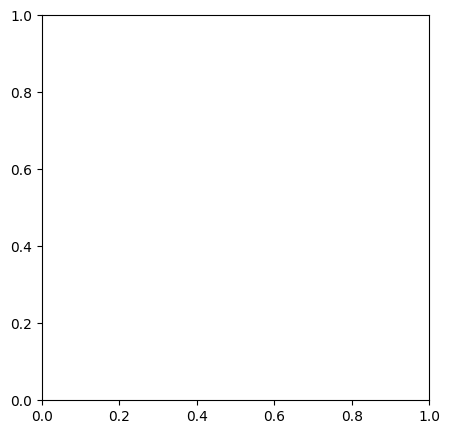

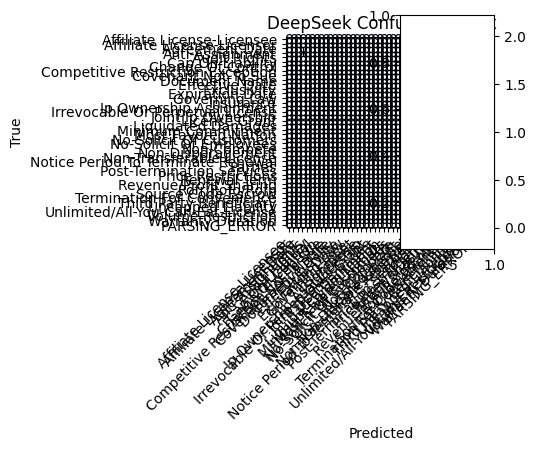

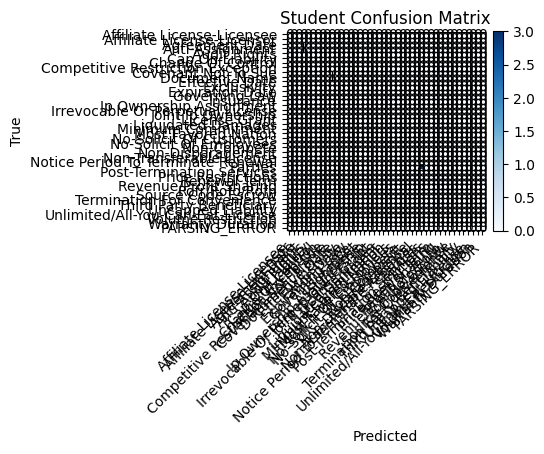

In [21]:
import os
import re
import json
import random
from typing import List, Tuple, Optional, Dict
import torch
import matplotlib.pyplot as plt

import litellm
from peft import PeftModel
from datasets import Dataset, DatasetDict
from unsloth import FastLanguageModel
from unsloth.chat_templates import get_chat_template

# -------------------- Config --------------------
N_SAMPLES = 5
TEMPERATURE = 0.1
MAX_NEW_TOKENS = 512
SEED = 42

PRINT_ERROR_SAMPLES = 3
RAW_SNIPPET_CHARS = 600
SHOW_JSON_SUBSTRING = True

# Teacher (DeepSeek via OpenRouter)
TEACHER_MODEL = "deepseek/deepseek-r1-0528"

# Student (HF Hub LoRA adapters) + Base model
try:
    STUDENT_MODEL_ID
except NameError:
    # If you trained/pushed a different adapter, set it here:
    STUDENT_MODEL_ID = "zenml/deepseek-cuad-gemma-3-12b-it-bnb-4bit"
try:
    BASE_MODEL_ID
except NameError:
    BASE_MODEL_ID = "unsloth/gemma-3-12b-it-unsloth-bnb-4bit"

# OpenRouter API key fallback
if not os.getenv("OPENROUTER_API_KEY") and os.getenv("DSWORKSHOP_OPENROUTER_API_KEY"):
    os.environ["OPENROUTER_API_KEY"] = os.getenv("DSWORKSHOP_OPENROUTER_API_KEY")
litellm.suppress_debug_info = True


# -------------------- Helpers --------------------
def derive_valid_labels_from_dataset(ds) -> List[str]:
    """Build the label schema from the dataset content (exclude NONE)."""
    if isinstance(ds, DatasetDict):
        base = ds["test"] if "test" in ds else next(iter(ds.values()))
    elif isinstance(ds, Dataset):
        base = ds
    else:
        raise RuntimeError("`dataset` must be a Hugging Face Dataset or DatasetDict in memory.")

    labels = set()
    for r in base:
        lab = (r.get("label") or "").strip()
        if lab and lab.upper() != "NONE":
            labels.add(lab)
    return sorted(labels)


def get_test_items(ds) -> List[dict]:
    """Return N non-NONE test items (shuffled)."""
    if isinstance(ds, DatasetDict):
        base = ds["test"] if "test" in ds else next(iter(ds.values()))
    elif isinstance(ds, Dataset):
        base = ds
    else:
        raise RuntimeError("`dataset` must be a Hugging Face Dataset or DatasetDict in memory.")
    items = [r for r in base if (r.get("label") or "").strip().upper() != "NONE"]
    random.seed(SEED)
    random.shuffle(items)
    return items[: min(N_SAMPLES, len(items))]


def create_prompt_json(sample: dict, valid_labels: List[str]) -> str:
    """JSON-structured prompt for both teacher and student (labels exclude NONE)."""
    return json.dumps(
        {
            "task": "classify_legal_clause",
            "instructions": (
                'Analyze the legal clause and provide a detailed rationale for why '
                'it belongs to a specific category, then classify it according to the provided schema. '
                'IMPORTANT: First explain your reasoning thoroughly, then provide the label. '
                'Your output must be valid JSON. '
                'Example format: {"rationale": "This clause describes... because...", "label": "Termination for Convenience"}'
            ),
            "schema": {
                "rationale": "Detailed explanation of why the clause belongs to this category",
                "label": "The classification category from the list of valid labels",
            },
            "valid_labels": valid_labels,
            "inputs": {
                "clause": (sample.get("clause") or "").strip(),
                "clause_with_context": (sample.get("clause_with_context") or "").strip(),
                "contract_type": (sample.get("contract_type") or "").strip() or "Unknown",
            },
        },
        ensure_ascii=False,
    )


def _strip_code_fences(text: str) -> str:
    """Remove ```json ...``` or ```...``` code fences if present."""
    if not text:
        return text
    if "```json" in text:
        start = text.find("```json")
        end = text.find("```", start + 7)
        if end > start:
            return text[start + 7 : end].strip()
    if "```" in text:
        start = text.find("```")
        end = text.find("```", start + 3)
        if end > start:
            return text[start + 3 : end].strip()
    return text


def _find_json_substring(text: str) -> Optional[str]:
    """Heuristically extract the largest {...} substring to parse as JSON."""
    if not text:
        return None
    start = text.find("{")
    end = text.rfind("}")
    if start == -1 or end == -1 or end <= start:
        return None
    return text[start : end + 1]


def _coerce_label_key(obj: Dict) -> Optional[str]:
    """Try common keys for label in a case-insensitive way, and also common wrappers."""
    candidates = [obj]
    for k in ["output", "response", "data", "result"]:
        if isinstance(obj.get(k), dict):
            candidates.append(obj[k])
    for cand in candidates:
        keys = {k.lower(): k for k in cand.keys()}
        for name in ["label", "category", "class", "prediction"]:
            if name in keys:
                val = cand[keys[name]]
                return val if isinstance(val, str) else (str(val) if val is not None else None)
    return None


def parse_with_diagnostics(text: str, valid_labels: List[str]) -> Tuple[str, Dict]:
    """
    Attempt to parse JSON and extract label with rich diagnostics.
    Returns (final_label_or_PARSING_ERROR, diagnostics_dict).
    """
    diag = {
        "ok": False,
        "error_code": None,
        "error_detail": None,
        "raw_snippet": (text or "")[:RAW_SNIPPET_CHARS],
        "json_substring": None,
        "parsed_label": None,
        "normalized_label": None,
    }

    if text is None or text.strip() == "":
        diag["error_code"] = "NO_RESPONSE"
        diag["error_detail"] = "Model returned empty response."
        return "PARSING_ERROR", diag

    cleaned = _strip_code_fences(text)
    json_str = _find_json_substring(cleaned)
    if not json_str:
        diag["error_code"] = "NO_JSON_FOUND"
        diag["error_detail"] = "Could not find brace-delimited JSON in response."
        return "PARSING_ERROR", diag
    diag["json_substring"] = json_str[:RAW_SNIPPET_CHARS] if SHOW_JSON_SUBSTRING else None

    try:
        obj = json.loads(json_str)
    except json.JSONDecodeError as e:
        diag["error_code"] = "JSON_DECODE_ERROR"
        diag["error_detail"] = f"{type(e).__name__}: {str(e)}"
        return "PARSING_ERROR", diag
    except Exception as e:
        diag["error_code"] = "JSON_PARSE_EXCEPTION"
        diag["error_detail"] = f"{type(e).__name__}: {str(e)}"
        return "PARSING_ERROR", diag

    label = _coerce_label_key(obj)
    if label is None or not str(label).strip():
        diag["error_code"] = "MISSING_LABEL_FIELD"
        diag["error_detail"] = "Parsed JSON but no usable 'label' found."
        return "PARSING_ERROR", diag

    label_norm = label.strip()
    diag["parsed_label"] = label
    diag["normalized_label"] = label_norm

    if label_norm not in valid_labels:
        diag["error_code"] = "INVALID_LABEL"
        diag["error_detail"] = f"Label '{label_norm}' not in valid label set."
        return "PARSING_ERROR", diag

    diag["ok"] = True
    return label_norm, diag


def _guess_max_seq_length(mid: str) -> int:
    mid = mid.lower()
    if "12b" in mid:
        return 4096
    if "1b" in mid:
        return 1024
    return 2048


def _ensure_base_matches_adapter(base_id: str, adapter_id: str) -> str:
    """If Gemma family/size mismatch, pick a compatible Unsloth base automatically."""
    base = base_id
    fam = "gemma-3" if "gemma-3" in adapter_id else ("gemma-2" if "gemma-2" in adapter_id else None)
    size = "12b" if "12b" in adapter_id else ("4b" if "4b" in adapter_id else ("1b" if "1b" in adapter_id else None))
    if fam and size and (fam not in base_id or size not in base_id):
        suggested = f"unsloth/{fam}-{size}-it-bnb-4bit" if fam == "gemma-2" else f"unsloth/{fam}-{size}-it-unsloth-bnb-4bit"
        print(f"⚠️ Detected base/adapter family mismatch. Switching base to: {suggested}")
        base = suggested
    return base


def load_student_model_if_needed():
    """Use preloaded student_model/student_tokenizer if available, else load from HF Hub."""
    if "student_model" in globals() and "student_tokenizer" in globals() and student_model is not None:
        return student_model, student_tokenizer

    base_id = _ensure_base_matches_adapter(BASE_MODEL_ID, STUDENT_MODEL_ID)
    model, tok = FastLanguageModel.from_pretrained(
        model_name=base_id,
        max_seq_length=_guess_max_seq_length(base_id),
        load_in_4bit=True,
        load_in_8bit=False,
    )
    FastLanguageModel.for_inference(model)
    tok = get_chat_template(tok, chat_template="gemma-3")
    model = PeftModel.from_pretrained(model, STUDENT_MODEL_ID)
    return model, tok


@torch.no_grad()
def student_predict(sample: dict, model, tokenizer, valid_labels: List[str]) -> str:
    """Generate student model response and return raw text."""
    prompt_json = create_prompt_json(sample, valid_labels)
    messages = [{"role": "user", "content": [{"type": "text", "text": prompt_json}]}]
    prompt_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True, tokenize=False)
    inputs = tokenizer([prompt_text], return_tensors="pt").to(model.device)
    outputs = model.generate(
        **inputs,
        max_new_tokens=MAX_NEW_TOKENS,
        temperature=TEMPERATURE,
        top_p=0.95,
        top_k=64,
        use_cache=True,
    )
    full = tokenizer.batch_decode(outputs)[0]
    return full[len(prompt_text):].strip()


def teacher_predict(sample: dict, valid_labels: List[str]) -> str:
    """
    Calls DeepSeek via OpenRouter using an enhanced prompt with a system message
    and few-shot examples to ensure reliable JSON output.
    """
    # The actual user query for the item we're evaluating.
    user_query_json = create_prompt_json(sample, valid_labels)

    # A more robust prompt using few-shot examples to guide the model's output format.
    # This is much more effective than a simple retry or a basic system instruction.
    messages = [
        {
            "role": "system",
            "content": "You are an expert legal AI. Your task is to analyze a legal clause and classify it. Your ONLY output must be a single, valid JSON object with 'rationale' and 'label' keys. Do not include markdown fences, explanations, or any other text outside the JSON structure."
        },
        # --- Example 1: A standard, clear-cut case ---
        {
            "role": "user",
            # A simplified user message is sufficient for the few-shot example
            "content": '{"task": "classify_legal_clause", "inputs": {"clause": "This Agreement shall be governed by the laws of the State of Delaware."}}',
        },
        {
            "role": "assistant",
            "content": '{"rationale": "The clause explicitly states that the agreement is governed by the laws of a specific jurisdiction, which is the defining characteristic of a Governing Law provision.", "label": "Governing Law"}',
        },
        # --- Example 2: A case where the clause does not match any category ---
        {
            "role": "user",
            "content": '{"task": "classify_legal_clause", "inputs": {"clause": "The parties shall meet on the first Monday of each month to review progress."}}',
        },
        {
            "role": "assistant",
            "content": '{"rationale": "This clause describes a routine operational arrangement but does not pertain to any of the specified legal categories.", "label": "NONE"}',
        },
        # --- The actual prompt for the item to be evaluated ---
        {"role": "user", "content": user_query_json},
    ]

    try:
        response = litellm.completion(
            model=f"openrouter/{TEACHER_MODEL}",
            messages=messages,
            temperature=TEMPERATURE,
            max_tokens=MAX_NEW_TOKENS,
            response_format={"type": "json_object"},
        )
        return response.choices[0].message.content or ""
    except Exception as e:
        # If the API call fails for any reason (e.g., network, rate limit), return an empty string.
        # The downstream parsing function will correctly handle this as a NO_RESPONSE error.
        print(f"API call to {TEACHER_MODEL} failed: {e}")
        return ""


def build_confusion(true_labels: List[str], pred_labels: List[str], classes: List[str]):
    idx = {c: i for i, c in enumerate(classes)}
    m = [[0 for _ in classes] for __ in classes]
    for t, p in zip(true_labels, pred_labels):
        if p not in idx:
            p = "PARSING_ERROR" if "PARSING_ERROR" in idx else p
        if t in idx and p in idx:
            m[idx[t]][idx[p]] += 1
    return m


def plot_confusion(cm, classes: List[str], title: str):
    fig, ax = plt.subplots(figsize=(5.5, 5))
    im = ax.imshow(cm, cmap="Blues", interpolation="nearest")
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_xticks(range(len(classes)))
    ax.set_yticks(range(len(classes)))
    ax.set_xticklabels(classes, rotation=45, ha="right")
    ax.set_yticklabels(classes)
    for i in range(len(classes)):
        for j in range(len(classes)):
            ax.text(j, i, str(cm[i][j]), ha="center", va="center", color="black")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    return fig, ax


# -------------------- Run Evaluation --------------------
if "dataset" not in globals():
    raise RuntimeError("Expected an in-memory `dataset` (Dataset or DatasetDict). Load it earlier with load_dataset(...).")

# 1) Dynamic label schema from your data (excludes NONE)
DYNAMIC_LABELS = derive_valid_labels_from_dataset(dataset)
if not DYNAMIC_LABELS:
    raise RuntimeError("No non-NONE labels detected in dataset; cannot evaluate.")
print(f"Evaluating on {N_SAMPLES} non-NONE examples.")
print(f"Valid labels ({len(DYNAMIC_LABELS)}): {', '.join(DYNAMIC_LABELS[:8])}{' ...' if len(DYNAMIC_LABELS) > 8 else ''}")

# 2) Sample non-NONE examples
samples = get_test_items(dataset)
if len(samples) == 0:
    raise RuntimeError("No non-NONE items available in the provided dataset/test split.")

# 3) Load student
stu_model, stu_tok = load_student_model_if_needed()
print(f"Student model loaded from HF: {STUDENT_MODEL_ID}")
if torch.cuda.is_available():
    props = torch.cuda.get_device_properties(0)
    print(f"Using GPU: {props.name}")

# 4) Evaluate both models
true_labels: List[str] = []
teacher_preds: List[str] = []
student_preds: List[str] = []

teacher_diags: List[Dict] = []
student_diags: List[Dict] = []

for i, s in enumerate(samples, 1):
    gold = (s.get("label") or "").strip()
    true_labels.append(gold)

    t_resp = teacher_predict(s, DYNAMIC_LABELS)
    t_label, t_diag = parse_with_diagnostics(t_resp, DYNAMIC_LABELS)
    teacher_diags.append(t_diag)
    teacher_preds.append(t_label)

    s_resp = student_predict(s, stu_model, stu_tok, DYNAMIC_LABELS)
    s_label, s_diag = parse_with_diagnostics(s_resp, DYNAMIC_LABELS)
    student_diags.append(s_diag)
    student_preds.append(s_label)

    print(f"[{i}] Gold={gold} | Teacher={t_label}{'' if t_diag['ok'] else ' (parse err)'} | Student={s_label}{'' if s_diag['ok'] else ' (parse err)'}")


# 5) Accuracies
def accuracy(y_true, y_pred):
    correct = sum(1 for a, b in zip(y_true, y_pred) if a == b)
    return correct, len(y_true), (correct / len(y_true)) if y_true else 0.0

t_correct, n, t_acc = accuracy(true_labels, teacher_preds)
s_correct, _, s_acc = accuracy(true_labels, student_preds)
print(f"\nTeacher (DeepSeek) accuracy: {t_correct}/{n} = {t_acc:.1%}")
print(f"Student (HF LoRA)  accuracy: {s_correct}/{n} = {s_acc:.1%}")


# 6) Diagnostics summary
def summarize_errors(diags: List[Dict], label: str):
    counts: Dict[str, int] = {}
    for d in diags:
        if not d["ok"]:
            code = d["error_code"] or "UNKNOWN"
            counts[code] = counts.get(code, 0) + 1
    total_errs = sum(counts.values())
    if total_errs == 0:
        print(f"\n{label}: No parsing errors ✅")
        return []
    print(f"\n{label}: Parsing errors = {total_errs}/{len(diags)}")
    for code, cnt in sorted(counts.items(), key=lambda x: x[1], reverse=True):
        print(f"  - {code}: {cnt}")
    failing_idxs = [i for i, d in enumerate(diags) if not d["ok"]]
    return failing_idxs

teacher_failing = summarize_errors(teacher_diags, "Teacher")
student_failing = summarize_errors(student_diags, "Student")

both_fail = sorted(set(teacher_failing).intersection(set(student_failing)))
if both_fail:
    print(f"\nBoth Teacher and Student failed on {len(both_fail)} of {len(samples)} samples: {[i+1 for i in both_fail[:10]]}")

def print_error_examples(diags: List[Dict], preds: List[str], tag: str, idxs: List[int]):
    shown = 0
    print(f"\n--- {tag}: Sample parsing failures (up to {PRINT_ERROR_SAMPLES}) ---")
    for i in idxs:
        if shown >= PRINT_ERROR_SAMPLES:
            break
        d = diags[i]
        if d["ok"]:
            continue
        print(f"[{i+1}] error_code={d['error_code']} detail={d['error_detail']}")
        print(f"Predicted token (bucket) = {preds[i]}")
        if SHOW_JSON_SUBSTRING and d.get("json_substring"):
            print(f"JSON substring: {d['json_substring'][:RAW_SNIPPET_CHARS]}")
        print(f"Raw response: {d['raw_snippet']}")
        shown += 1
    if shown == 0:
        print("No failures to show.")

print_error_examples(teacher_diags, teacher_preds, "Teacher", teacher_failing)
print_error_examples(student_diags, student_preds, "Student", student_failing)

# 7) Confusion matrices

# The matrix schema should be all possible valid labels derived from the dataset.
all_classes = DYNAMIC_LABELS[:] # Use a copy to be safe

# Add the "PARSING_ERROR" category to the schema only if it actually occurred.
# This ensures the matrix has a row/column for parsing errors when needed.
if "PARSING_ERROR" in teacher_preds or "PARSING_ERROR" in student_preds:
    if "PARSING_ERROR" not in all_classes:
        all_classes.append("PARSING_ERROR")

t_cm = build_confusion(true_labels, teacher_preds, all_classes)
s_cm = build_confusion(true_labels, student_preds, all_classes)

plt.figure(figsize=(11, 5))
plt.subplot(1, 2, 1)
plot_confusion(t_cm, all_classes, title="DeepSeek Confusion Matrix")
plt.subplot(1, 2, 2)
plot_confusion(s_cm, all_classes, title="Student Confusion Matrix")
plt.show()


Evaluating on 5 non-NONE examples.

Valid labels (41): Affiliate License-Licensee, Affiliate License-Licensor, Agreement Date, Anti-Assignment, Audit 
Rights, Cap On Liability, Change Of Control, Competitive Restriction Exception ...

Student model loaded from HF: zenml/deepseek-cuad-gemma-3-12b-it-bnb-4bit

Using GPU: NVIDIA A100-SXM4-40GB

[1] Gold=Parties | Teacher=Parties | Student=Parties

[2] Gold=Anti-Assignment | Teacher=PARSING_ERROR (parse err) | Student=Anti-Assignment

[3] Gold=Parties | Teacher=PARSING_ERROR (parse err) | Student=Parties

[4] Gold=Document Name | Teacher=PARSING_ERROR (parse err) | Student=Document Name

[5] Gold=Parties | Teacher=PARSING_ERROR (parse err) | Student=Parties

Teacher (DeepSeek) accuracy: 1/5 = 20.0%

Student (HF LoRA)  accuracy: 5/5 = 100.0%

Teacher: Parsing errors = 4/5

- NO_JSON_FOUND: 4

Student: No parsing errors ✅

--- Teacher: Sample parsing failures (up to 3) ---

[2] error_code=NO_JSON_FOUND detail=Could not find brace-delimited JSON in response.

Predicted token (bucket) = PARSING_ERROR

Raw response: {
  "rationale": "This clause explicitly restricts the assignment

[3] error_code=NO_JSON_FOUND detail=Could not find brace-delimited JSON in response.

Predicted token (bucket) = PARSING_ERROR

Raw response: {"rationale": "The clause 'ANR PIPELINE COMPANY

[4] error_code=NO_JSON_FOUND detail=Could not find brace-delimited JSON in response.

Predicted token (bucket) = PARSING_ERROR

Raw response: 
[-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

--- Student: Sample parsing failures (up to 3) ---

No failures to show.

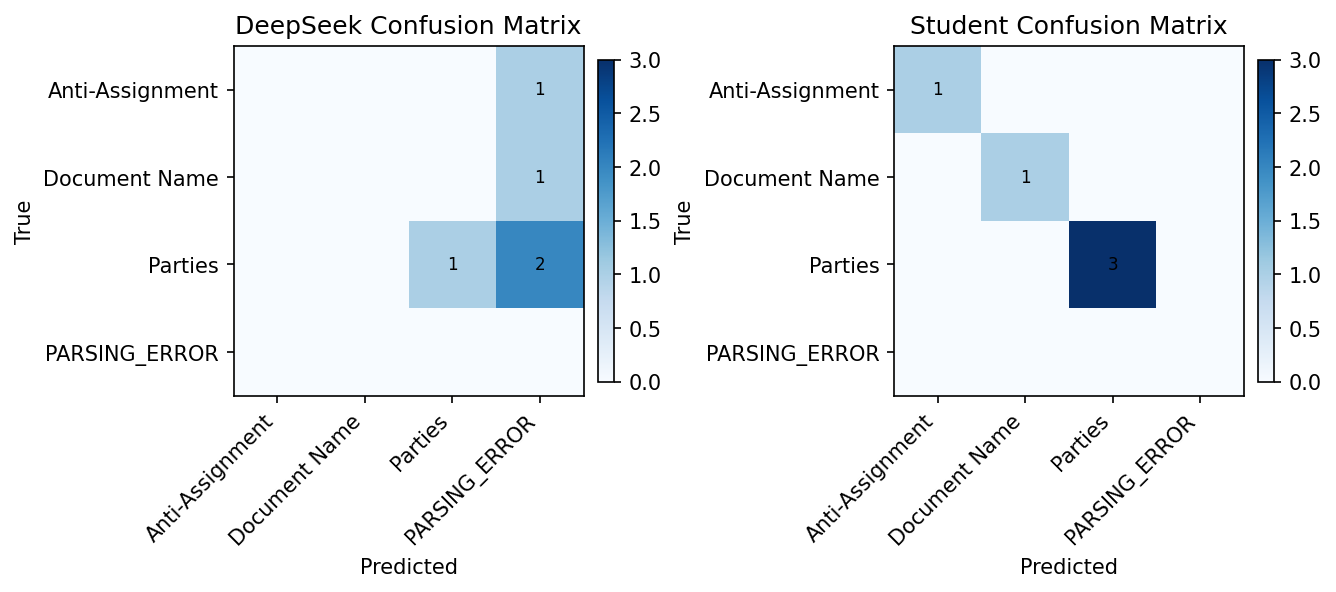

In [24]:
# GPT-5-PRO
import os
import re
import json
import random
from typing import List, Tuple, Optional, Dict, Iterable
import torch
import matplotlib.pyplot as plt

import litellm
from peft import PeftModel
from datasets import Dataset, DatasetDict
from unsloth import FastLanguageModel
from unsloth.chat_templates import get_chat_template

# -------------------- Config --------------------
N_SAMPLES = 5
TEMPERATURE = 0.1
MAX_NEW_TOKENS = 512
SEED = 42

PRINT_ERROR_SAMPLES = 3
RAW_SNIPPET_CHARS = 600
SHOW_JSON_SUBSTRING = True

# Teacher (DeepSeek via OpenRouter)
TEACHER_MODEL = "deepseek/deepseek-r1-0528"

# Student (HF Hub LoRA adapters) + Base model
try:
    STUDENT_MODEL_ID
except NameError:
    # If you trained/pushed a different adapter, set it here:
    STUDENT_MODEL_ID = "zenml/deepseek-cuad-gemma-3-12b-it-bnb-4bit"
try:
    BASE_MODEL_ID
except NameError:
    BASE_MODEL_ID = "unsloth/gemma-3-12b-it-unsloth-bnb-4bit"

# OpenRouter API key fallback
if not os.getenv("OPENROUTER_API_KEY") and os.getenv("DSWORKSHOP_OPENROUTER_API_KEY"):
    os.environ["OPENROUTER_API_KEY"] = os.getenv("DSWORKSHOP_OPENROUTER_API_KEY")
litellm.suppress_debug_info = True


# -------------------- Helpers --------------------
def used_classes(y_true: List[str], preds_list: Iterable[List[str]], base_order: List[str]) -> List[str]:
    """Keep only classes seen in y_true or any preds; preserve base_order; include PARSING_ERROR if present."""
    used = set(l for l in y_true if l)
    for preds in preds_list:
        used.update(l for l in preds if l)
    ordered = [c for c in base_order if c in used]  # preserve dataset's stable order
    if any("PARSING_ERROR" in preds for preds in preds_list):
        if "PARSING_ERROR" not in ordered:
            ordered.append("PARSING_ERROR")
    return ordered


def derive_valid_labels_from_dataset(ds) -> List[str]:
    """Build the label schema from the dataset content (exclude NONE)."""
    if isinstance(ds, DatasetDict):
        base = ds["test"] if "test" in ds else next(iter(ds.values()))
    elif isinstance(ds, Dataset):
        base = ds
    else:
        raise RuntimeError("`dataset` must be a Hugging Face Dataset or DatasetDict in memory.")

    labels = set()
    for r in base:
        lab = (r.get("label") or "").strip()
        if lab and lab.upper() != "NONE":
            labels.add(lab)
    return sorted(labels)


def get_test_items(ds) -> List[dict]:
    """Return N non-NONE test items (shuffled)."""
    if isinstance(ds, DatasetDict):
        base = ds["test"] if "test" in ds else next(iter(ds.values()))
    elif isinstance(ds, Dataset):
        base = ds
    else:
        raise RuntimeError("`dataset` must be a Hugging Face Dataset or DatasetDict in memory.")
    items = [r for r in base if (r.get("label") or "").strip().upper() != "NONE"]
    random.seed(SEED)
    random.shuffle(items)
    return items[: min(N_SAMPLES, len(items))]


def create_prompt_json(sample: dict, valid_labels: List[str]) -> str:
    """JSON-structured prompt for both teacher and student (labels exclude NONE)."""
    return json.dumps(
        {
            "task": "classify_legal_clause",
            "instructions": (
                'Analyze the legal clause and provide a detailed rationale for why '
                'it belongs to a specific category, then classify it according to the provided schema. '
                'IMPORTANT: First explain your reasoning thoroughly, then provide the label. '
                'Your output must be valid JSON. '
                'Example format: {"rationale": "This clause describes... because...", "label": "Termination for Convenience"}'
            ),
            "schema": {
                "rationale": "Detailed explanation of why the clause belongs to this category",
                "label": "The classification category from the list of valid labels",
            },
            "valid_labels": valid_labels,
            "inputs": {
                "clause": (sample.get("clause") or "").strip(),
                "clause_with_context": (sample.get("clause_with_context") or "").strip(),
                "contract_type": (sample.get("contract_type") or "").strip() or "Unknown",
            },
        },
        ensure_ascii=False,
    )


def _strip_code_fences(text: str) -> str:
    """Remove ```json ...``` or ```...``` code fences if present."""
    if not text:
        return text
    if "```json" in text:
        start = text.find("```json")
        end = text.find("```", start + 7)
        if end > start:
            return text[start + 7 : end].strip()
    if "```" in text:
        start = text.find("```")
        end = text.find("```", start + 3)
        if end > start:
            return text[start + 3 : end].strip()
    return text


def _find_json_substring(text: str) -> Optional[str]:
    """Heuristically extract the largest {...} substring to parse as JSON."""
    if not text:
        return None
    start = text.find("{")
    end = text.rfind("}")
    if start == -1 or end == -1 or end <= start:
        return None
    return text[start : end + 1]


def _coerce_label_key(obj: Dict) -> Optional[str]:
    """Try common keys for label in a case-insensitive way, and also common wrappers."""
    candidates = [obj]
    for k in ["output", "response", "data", "result"]:
        if isinstance(obj.get(k), dict):
            candidates.append(obj[k])
    for cand in candidates:
        keys = {k.lower(): k for k in cand.keys()}
        for name in ["label", "category", "class", "prediction"]:
            if name in keys:
                val = cand[keys[name]]
                return val if isinstance(val, str) else (str(val) if val is not None else None)
    return None


def parse_with_diagnostics(text: str, valid_labels: List[str]) -> Tuple[str, Dict]:
    """
    Attempt to parse JSON and extract label with rich diagnostics.
    Returns (final_label_or_PARSING_ERROR, diagnostics_dict).
    """
    diag = {
        "ok": False,
        "error_code": None,
        "error_detail": None,
        "raw_snippet": (text or "")[:RAW_SNIPPET_CHARS],
        "json_substring": None,
        "parsed_label": None,
        "normalized_label": None,
    }

    if text is None or text.strip() == "":
        diag["error_code"] = "NO_RESPONSE"
        diag["error_detail"] = "Model returned empty response."
        return "PARSING_ERROR", diag

    cleaned = _strip_code_fences(text)
    json_str = _find_json_substring(cleaned)
    if not json_str:
        diag["error_code"] = "NO_JSON_FOUND"
        diag["error_detail"] = "Could not find brace-delimited JSON in response."
        return "PARSING_ERROR", diag
    diag["json_substring"] = json_str[:RAW_SNIPPET_CHARS] if SHOW_JSON_SUBSTRING else None

    try:
        obj = json.loads(json_str)
    except json.JSONDecodeError as e:
        diag["error_code"] = "JSON_DECODE_ERROR"
        diag["error_detail"] = f"{type(e).__name__}: {str(e)}"
        return "PARSING_ERROR", diag
    except Exception as e:
        diag["error_code"] = "JSON_PARSE_EXCEPTION"
        diag["error_detail"] = f"{type(e).__name__}: {str(e)}"
        return "PARSING_ERROR", diag

    label = _coerce_label_key(obj)
    if label is None or not str(label).strip():
        diag["error_code"] = "MISSING_LABEL_FIELD"
        diag["error_detail"] = "Parsed JSON but no usable 'label' found."
        return "PARSING_ERROR", diag

    label_norm = label.strip()
    diag["parsed_label"] = label
    diag["normalized_label"] = label_norm

    if label_norm not in valid_labels:
        diag["error_code"] = "INVALID_LABEL"
        diag["error_detail"] = f"Label '{label_norm}' not in valid label set."
        return "PARSING_ERROR", diag

    diag["ok"] = True
    return label_norm, diag


def _guess_max_seq_length(mid: str) -> int:
    mid = mid.lower()
    if "12b" in mid:
        return 4096
    if "1b" in mid:
        return 1024
    return 2048


def _ensure_base_matches_adapter(base_id: str, adapter_id: str) -> str:
    """If Gemma family/size mismatch, pick a compatible Unsloth base automatically."""
    base = base_id
    fam = "gemma-3" if "gemma-3" in adapter_id else ("gemma-2" if "gemma-2" in adapter_id else None)
    size = "12b" if "12b" in adapter_id else ("4b" if "4b" in adapter_id else ("1b" if "1b" in adapter_id else None))
    if fam and size and (fam not in base_id or size not in base_id):
        suggested = f"unsloth/{fam}-{size}-it-bnb-4bit" if fam == "gemma-2" else f"unsloth/{fam}-{size}-it-unsloth-bnb-4bit"
        print(f"⚠️ Detected base/adapter family mismatch. Switching base to: {suggested}")
        base = suggested
    return base


def load_student_model_if_needed():
    """Use preloaded student_model/student_tokenizer if available, else load from HF Hub."""
    if "student_model" in globals() and "student_tokenizer" in globals() and student_model is not None:
        return student_model, student_tokenizer

    base_id = _ensure_base_matches_adapter(BASE_MODEL_ID, STUDENT_MODEL_ID)
    model, tok = FastLanguageModel.from_pretrained(
        model_name=base_id,
        max_seq_length=_guess_max_seq_length(base_id),
        load_in_4bit=True,
        load_in_8bit=False,
    )
    FastLanguageModel.for_inference(model)
    tok = get_chat_template(tok, chat_template="gemma-3")
    model = PeftModel.from_pretrained(model, STUDENT_MODEL_ID)
    return model, tok


@torch.no_grad()
def student_predict(sample: dict, model, tokenizer, valid_labels: List[str]) -> str:
    """Generate student model response and return raw text."""
    prompt_json = create_prompt_json(sample, valid_labels)
    messages = [{"role": "user", "content": [{"type": "text", "text": prompt_json}]}]
    prompt_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True, tokenize=False)
    inputs = tokenizer([prompt_text], return_tensors="pt").to(model.device)
    outputs = model.generate(
        **inputs,
        max_new_tokens=MAX_NEW_TOKENS,
        temperature=TEMPERATURE,
        top_p=0.95,
        top_k=64,
        use_cache=True,
    )
    full = tokenizer.batch_decode(outputs)[0]
    return full[len(prompt_text):].strip()


def teacher_predict(sample: dict, valid_labels: List[str]) -> str:
    """
    Calls DeepSeek via OpenRouter using an enhanced prompt with a system message
    and few-shot examples to ensure reliable JSON output.
    """
    # The actual user query for the item we're evaluating.
    user_query_json = create_prompt_json(sample, valid_labels)

    # A more robust prompt using few-shot examples to guide the model's output format.
    # This is much more effective than a simple retry or a basic system instruction.
    messages = [
        {
            "role": "system",
            "content": "You are an expert legal AI. Your task is to analyze a legal clause and classify it. Your ONLY output must be a single, valid JSON object with 'rationale' and 'label' keys. Do not include markdown fences, explanations, or any other text outside the JSON structure."
        },
        # --- Example 1: A standard, clear-cut case ---
        {
            "role": "user",
            # A simplified user message is sufficient for the few-shot example
            "content": '{"task": "classify_legal_clause", "inputs": {"clause": "This Agreement shall be governed by the laws of the State of Delaware."}}',
        },
        {
            "role": "assistant",
            "content": '{"rationale": "The clause explicitly states that the agreement is governed by the laws of a specific jurisdiction, which is the defining characteristic of a Governing Law provision.", "label": "Governing Law"}',
        },
        # --- Example 2: A case where the clause does not match any category ---
        {
            "role": "user",
            "content": '{"task": "classify_legal_clause", "inputs": {"clause": "The parties shall meet on the first Monday of each month to review progress."}}',
        },
        {
            "role": "assistant",
            "content": '{"rationale": "This clause describes a routine operational arrangement but does not pertain to any of the specified legal categories.", "label": "NONE"}',
        },
        # --- The actual prompt for the item to be evaluated ---
        {"role": "user", "content": user_query_json},
    ]

    try:
        response = litellm.completion(
            model=f"openrouter/{TEACHER_MODEL}",
            messages=messages,
            temperature=TEMPERATURE,
            max_tokens=MAX_NEW_TOKENS,
            response_format={"type": "json_object"},
        )
        return response.choices[0].message.content or ""
    except Exception as e:
        # If the API call fails for any reason (e.g., network, rate limit), return an empty string.
        # The downstream parsing function will correctly handle this as a NO_RESPONSE error.
        print(f"API call to {TEACHER_MODEL} failed: {e}")
        return ""


def build_confusion(true_labels: List[str], pred_labels: List[str], classes: List[str]):
    idx = {c: i for i, c in enumerate(classes)}
    m = [[0 for _ in classes] for __ in classes]
    for t, p in zip(true_labels, pred_labels):
        if p not in idx:
            p = "PARSING_ERROR" if "PARSING_ERROR" in idx else p
        if t in idx and p in idx:
            m[idx[t]][idx[p]] += 1
    return m


def plot_confusion(cm: List[List[int]], classes: List[str], title: str, ax: plt.Axes, vmax: Optional[int] = None) -> None:
    """Plot a confusion matrix onto a provided Axes."""
    im = ax.imshow(cm, cmap="Blues", interpolation="nearest", aspect="equal", vmin=0, vmax=vmax)
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

    n = len(classes)
    tick_fs = 10 if n <= 12 else max(6, 12 - 0.25 * (n - 12))  # shrink ticks gracefully
    ax.set_xticks(range(n)); ax.set_yticks(range(n))
    ax.set_xticklabels(classes, rotation=45, ha="right", fontsize=tick_fs)
    ax.set_yticklabels(classes, fontsize=tick_fs)

    # Annotate only non-zero cells to cut clutter; keep text readable.
    ann_fs = max(6, tick_fs - 2)
    for i in range(n):
        for j in range(n):
            v = cm[i][j]
            if v != 0:
                ax.text(j, i, str(v), ha="center", va="center", fontsize=ann_fs, color="black")

    ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)



# -------------------- Run Evaluation --------------------
if "dataset" not in globals():
    raise RuntimeError("Expected an in-memory `dataset` (Dataset or DatasetDict). Load it earlier with load_dataset(...).")

# 1) Dynamic label schema from your data (excludes NONE)
DYNAMIC_LABELS = derive_valid_labels_from_dataset(dataset)
if not DYNAMIC_LABELS:
    raise RuntimeError("No non-NONE labels detected in dataset; cannot evaluate.")
print(f"Evaluating on {N_SAMPLES} non-NONE examples.")
print(f"Valid labels ({len(DYNAMIC_LABELS)}): {', '.join(DYNAMIC_LABELS[:8])}{' ...' if len(DYNAMIC_LABELS) > 8 else ''}")

# 2) Sample non-NONE examples
samples = get_test_items(dataset)
if len(samples) == 0:
    raise RuntimeError("No non-NONE items available in the provided dataset/test split.")

# 3) Load student
stu_model, stu_tok = load_student_model_if_needed()
print(f"Student model loaded from HF: {STUDENT_MODEL_ID}")
if torch.cuda.is_available():
    props = torch.cuda.get_device_properties(0)
    print(f"Using GPU: {props.name}")

# 4) Evaluate both models
true_labels: List[str] = []
teacher_preds: List[str] = []
student_preds: List[str] = []

teacher_diags: List[Dict] = []
student_diags: List[Dict] = []

for i, s in enumerate(samples, 1):
    gold = (s.get("label") or "").strip()
    true_labels.append(gold)

    t_resp = teacher_predict(s, DYNAMIC_LABELS)
    t_label, t_diag = parse_with_diagnostics(t_resp, DYNAMIC_LABELS)
    teacher_diags.append(t_diag)
    teacher_preds.append(t_label)

    s_resp = student_predict(s, stu_model, stu_tok, DYNAMIC_LABELS)
    s_label, s_diag = parse_with_diagnostics(s_resp, DYNAMIC_LABELS)
    student_diags.append(s_diag)
    student_preds.append(s_label)

    print(f"[{i}] Gold={gold} | Teacher={t_label}{'' if t_diag['ok'] else ' (parse err)'} | Student={s_label}{'' if s_diag['ok'] else ' (parse err)'}")


# 5) Accuracies
def accuracy(y_true, y_pred):
    correct = sum(1 for a, b in zip(y_true, y_pred) if a == b)
    return correct, len(y_true), (correct / len(y_true)) if y_true else 0.0

t_correct, n, t_acc = accuracy(true_labels, teacher_preds)
s_correct, _, s_acc = accuracy(true_labels, student_preds)
print(f"\nTeacher (DeepSeek) accuracy: {t_correct}/{n} = {t_acc:.1%}")
print(f"Student (HF LoRA)  accuracy: {s_correct}/{n} = {s_acc:.1%}")


# 6) Diagnostics summary
def summarize_errors(diags: List[Dict], label: str):
    counts: Dict[str, int] = {}
    for d in diags:
        if not d["ok"]:
            code = d["error_code"] or "UNKNOWN"
            counts[code] = counts.get(code, 0) + 1
    total_errs = sum(counts.values())
    if total_errs == 0:
        print(f"\n{label}: No parsing errors ✅")
        return []
    print(f"\n{label}: Parsing errors = {total_errs}/{len(diags)}")
    for code, cnt in sorted(counts.items(), key=lambda x: x[1], reverse=True):
        print(f"  - {code}: {cnt}")
    failing_idxs = [i for i, d in enumerate(diags) if not d["ok"]]
    return failing_idxs

teacher_failing = summarize_errors(teacher_diags, "Teacher")
student_failing = summarize_errors(student_diags, "Student")

both_fail = sorted(set(teacher_failing).intersection(set(student_failing)))
if both_fail:
    print(f"\nBoth Teacher and Student failed on {len(both_fail)} of {len(samples)} samples: {[i+1 for i in both_fail[:10]]}")

def print_error_examples(diags: List[Dict], preds: List[str], tag: str, idxs: List[int]):
    shown = 0
    print(f"\n--- {tag}: Sample parsing failures (up to {PRINT_ERROR_SAMPLES}) ---")
    for i in idxs:
        if shown >= PRINT_ERROR_SAMPLES:
            break
        d = diags[i]
        if d["ok"]:
            continue
        print(f"[{i+1}] error_code={d['error_code']} detail={d['error_detail']}")
        print(f"Predicted token (bucket) = {preds[i]}")
        if SHOW_JSON_SUBSTRING and d.get("json_substring"):
            print(f"JSON substring: {d['json_substring'][:RAW_SNIPPET_CHARS]}")
        print(f"Raw response: {d['raw_snippet']}")
        shown += 1
    if shown == 0:
        print("No failures to show.")

print_error_examples(teacher_diags, teacher_preds, "Teacher", teacher_failing)
print_error_examples(student_diags, student_preds, "Student", student_failing)

# 7) Confusion matrices (only show classes that actually occurred)
classes = used_classes(true_labels, [teacher_preds, student_preds], DYNAMIC_LABELS)
t_cm = build_confusion(true_labels, teacher_preds, classes)
s_cm = build_confusion(true_labels, student_preds, classes)

# Shared color scale so intensities are comparable
vmax = max((max(row) for row in t_cm), default=0)
vmax = max(vmax, max((max(row) for row in s_cm), default=0))

# Dynamic sizing: ~0.6 in per class; widen for two panels; cap minimums so small cases still look good
cell = 0.6
n = max(1, len(classes))
fig_w = max(8, 2 * n * cell + 4)   # 2 mats side-by-side + margins
fig_h = max(5, n * cell + 2)

fig, axes = plt.subplots(1, 2, figsize=(fig_w, fig_h), dpi=150, constrained_layout=True)
plot_confusion(t_cm, classes, title="DeepSeek Confusion Matrix", ax=axes[0], vmax=vmax)
plot_confusion(s_cm, classes, title="Student Confusion Matrix",  ax=axes[1], vmax=vmax)
plt.show()



## Finetuning Models in Production

![](https://github.com/strickvl/deepseek-distillation-workshop-2025/blob/main/assets/hidden-debt.jpg?raw=true)

In [22]:
from typing import Dict
from zenml import step, pipeline

@step
def get_dataset(dataset_name: str) -> str:
    return dataset_name

@step
def train_model(dataset: str) -> str:
    # load model
    # train model
    # save model
    return "my_model"

@step
def evaluate_model(model: str) -> Dict[str, float]:
    # load test data
    # run inference on test data
    # calculate accuracy
    return {"accuracy": 0.95}

@pipeline
def distillation_pipeline():
    dataset = get_dataset("my_dataset")
    model = train_model(dataset)
    metrics = evaluate_model(model)
    return metrics

distillation_pipeline()

Initiating a new run for the pipeline: distillation_pipeline.
Reloading configuration file /root/.zen/config.yaml
Registered new pipeline: distillation_pipeline.
In a future release, the default Python package installer used by ZenML to build container images for your containerized pipelines will change from 'pip' to 'uv'. To maintain current behavior, you can explicitly set python_package_installer=PythonPackageInstaller.PIP in your DockerSettings.
Using user: default
Using stack: default
  artifact_store: default
  orchestrator: default
You can visualize your pipeline runs in the ZenML Dashboard. In order to try it locally, please run zenml login --local.
Step get_dataset has started.
Step get_dataset has finished in 0.190s.
Step train_model has started.
Step train_model has finished in 0.053s.
Step evaluate_model has started.
Step evaluate_model has finished in 0.241s.
Pipeline run has finished in 2.534s.


PipelineRunResponse(body=PipelineRunResponseBody(created=datetime.datetime(2025, 8, 16, 9, 32, 25, 783149), updated=datetime.datetime(2025, 8, 16, 9, 32, 28, 227489), user_id=UUID('8b2253e8-0646-405d-b90c-59c60314b3a1'), project_id=UUID('49b72bc2-71ae-4bb4-91df-a194a8c59134'), status=<ExecutionStatus.COMPLETED: 'completed'>, stack=StackResponse(body=StackResponseBody(created=datetime.datetime(2025, 8, 16, 9, 10, 8, 471037), updated=datetime.datetime(2025, 8, 16, 9, 10, 8, 471062), user_id=None), metadata=None, resources=None, id=UUID('b2661fdf-afaf-41d5-b914-0a72b28f8606'), permission_denied=False, name='default'), pipeline=PipelineResponse(body=PipelineResponseBody(created=datetime.datetime(2025, 8, 16, 9, 32, 25, 529925), updated=datetime.datetime(2025, 8, 16, 9, 32, 25, 529954), user_id=UUID('8b2253e8-0646-405d-b90c-59c60314b3a1'), project_id=UUID('49b72bc2-71ae-4bb4-91df-a194a8c59134')), metadata=None, resources=None, id=UUID('e915f3e5-e59f-49d3-b253-04a49eb67ffb'), permission_deni


## Next Steps



## Conclusion + Audience Questions
